In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib qt5
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from copy import deepcopy
from scipy.optimize import curve_fit


from qick import *
from qick.helpers import gauss

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq
import Pyro4.util

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [3]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence
import experiments as meas
from TomoAnalysis import TomoAnalysis
tomo_analysis = TomoAnalysis(nb_qubits=3)
import qutip as qt
import matplotlib.style as style
style.use('S:\Connie\prx.mplstyle')

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

In [4]:
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi_dict = dict(Z=psiZ, X=psiX, Y=psiY)

psis = dict() # psis in the ZZZ basis
for i, label_numeric in enumerate(tomo_analysis.calib_order_numeric):
    psis.update({label_numeric:tomo_analysis.psi_basis['ZZZ'][i]})
id3q = qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))
id2q = qt.tensor(qt.qeye(2), qt.qeye(2))

In [5]:
def get_qram_qSLR_state_from_rho(init_rho_SI, post_select=False, post_select_state=None):
    """
    init_rho_SI should be a np array
    """
    # in order |00>, |01>, |10>, |11> for Q0 (switch), Q1 (input)
    SI_to_SLR = [psis['000'], -1j*psis['010'], psis['100'], -1j*psis['101']]
    # SI_to_SLR = [psis['000'], psis['010'], psis['100'], psis['101']]

    assert np.shape(init_rho_SI) == id2q.shape
    rho_final_SLR = 0*qt.ket2dm(psis['000'])
    # print('constructing final state on |switch, out1, out2>')
    for i in range(len(SI_to_SLR)):
        slr_ket_i = SI_to_SLR[i]
        for j in range(len(SI_to_SLR)):
            slr_ket_j = SI_to_SLR[j]
            mat_el = init_rho_SI[i, j]
            rho_final_SLR += mat_el * slr_ket_i * slr_ket_j.dag()
    return rho_final_SLR.unit()

def name_to_state_2q(init_state): # in format |QA>|QB>
    Qa, Qb, _ = init_state.split('>')
    Qa = Qa[1:]
    Qb = Qb[1:]
    psi_name_dict = {
        '0':psiZ[0],
        '1':psiZ[1],
        '0+1':(psiZ[0]+psiZ[1]).unit(),
        '0-1':(psiZ[0]-psiZ[1]).unit(), 
        '0+i':(psiZ[0]+1j*psiZ[1]).unit(), 
        '0-i':(psiZ[0]-1j*psiZ[1]).unit(), 
    }
    try:
        psiA = psi_name_dict[Qa]
    except:
        print(f'QA state {Qa} is not an allowed cardinal state')
    try:
        psiB = psi_name_dict[Qb]
    except:
        print(f'QB state {Qb} is not an allowed cardinal state')
    return qt.tensor(psiA, psiB)


In [6]:
tomo_qubits = [0, 2, 3]

In [7]:
z = 1.96 # student's number for the error bars of 95% confidence

In [8]:
def ceil_decimal(array, decimals=0):
  """Rounds up the elements of a NumPy array to the specified decimal place.

  Args:
    array: The NumPy array to round up.
    decimals: The number of decimal places to round to (default: 0).

  Returns:
    A new NumPy array with the rounded up values.
  """
  factor = 10**decimals
  return np.ceil(array * factor) / factor

# Save paths

In [9]:
save_plot_path = 'S:\\QRAM\\qram_4QR2\\plots\\paper'

# Formatting

In [10]:
color_switch = '#ff7f50'
color_input = '#468499'
color_q2 = '#E16F8F'
color_basis = '#66CDAA'

def CQ_from_init(init_state):
    _init_state = init_state.replace('|', '')
    q0, q1 = _init_state[:-1].split('>')
    if q0 == '0+1' or q0=='0+i':
        if q1 != '0+1' and q1 !='0+i':
            return 'QrCi'
        return 'QrQi'

    else: 
        if q1 == '0+1' or q1=='0+i':
            return 'CrQi'
        return 'CrCi'

def color_from_cq(cq):
    if cq == 'QrCi':
        return color_switch
    elif cq == 'QrQi':
        return color_q2
    elif cq == 'CrQi':
        return color_input
    elif cq == 'CrCi':
        return color_basis

def latex_from_cq(cq):
    return cq

    if cq == 'QsCi':
        return '$Q_\mathrm{switch}C_\mathrm{input}$'
    elif cq == 'QsQi':
        return '$Q_\mathrm{switch}Q_\mathrm{input}$'
    elif cq == 'CsQi':
        return '$C_\mathrm{switch}Q_\mathrm{input}$'
    elif cq == 'CsCi':
        return '$C_\mathrm{switch}C_\mathrm{input}$'


# Import 2q tomo

In [11]:
# RETRIEVE SAVED 2Q TOMO INITIAL STATES FROM MEASUREMENT
rho_MLE_ZZ_2Q_filepath = 'S:\QRAM\qram_4QR2\data\data_250119\\202502111059_init_rhoMLE_ZZ_2Q_01.npz'

print(f'Using rho_MLE_ZZ for Q0/Q1 from file {rho_MLE_ZZ_2Q_filepath}')

rho_MLE_ZZ_dict = dict()
with np.load(rho_MLE_ZZ_2Q_filepath) as npzfile:
    for key in npzfile.keys():
        rho_MLE_ZZ_dict.update({key:npzfile[key]})
print(f'rho_MLE_ZZ_dict retrieved with init_states {rho_MLE_ZZ_dict.keys()}')

Using rho_MLE_ZZ for Q0/Q1 from file S:\QRAM\qram_4QR2\data\data_250119\202502111059_init_rhoMLE_ZZ_2Q_01.npz
rho_MLE_ZZ_dict retrieved with init_states dict_keys(['|0>|0>', '|0>|1>', '|0>|0+1>', '|0>|0+i>', '|1>|0>', '|1>|1>', '|1>|0+1>', '|1>|0+i>', '|0+1>|0>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0+i>', '|0+i>|0>', '|0+i>|1>', '|0+i>|0+1>', '|0+i>|0+i>'])


# Load evolv mats

In [12]:
evol_mats_path = "S:\\QRAM\\qram_4QR2\\evol_mats"

In [13]:
qA, qB, qC = tomo_qubits
evol_mats_filename = f'evol_mats_{qA}{qB}{qC}.npz'

qA, qB, qC = tomo_qubits
evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
# evol_mats_file_path = os.path.join(evol_mats_path, f'evol_mats_{qA}{qB}{qC}_test.npz')
print(f'Using evol mats from file {evol_mats_file_path}')

evol_mats = dict()
with np.load(evol_mats_file_path) as npzfile:
    for key in npzfile.keys():
        evol_mats.update({key:npzfile[key]})

Using evol mats from file S:\QRAM\qram_4QR2\evol_mats\evol_mats_023.npz


# Get fids grids and n_tomo

In [14]:
use_init_2q_state = True
plot = True

data_path = "S:\QRAM\qram_4QR2\data\data_250119\\"

fids_grids_filepath_1protocol = "202502120248_ntomocorrected_3Q_023_fids_grids.npz"
fids_grids_filepath_3protocol = "202502120636_ntomocorrected_3Q_023_fids_grids.npz"
fids_grids_filepath_5protocol = "202502121025_ntomocorrected_3Q_023_fids_grids.npz"
fids_grids_filepath_7protocol = "202502121415_ntomocorrected_3Q_023_fids_grids.npz"
fids_grids_filepath_9protocol = "202502130312_ntomocorrected_3Q_023_fids_grids.npz"
fids_grids_filepath_11protocol = "202502130703_ntomocorrected_3Q_023_fids_grids.npz"

fids_grids_filepaths = [fids_grids_filepath_1protocol, fids_grids_filepath_3protocol, fids_grids_filepath_5protocol, fids_grids_filepath_7protocol, fids_grids_filepath_9protocol, fids_grids_filepath_11protocol]

In [15]:
# fids_grids_dict structure: fids_grids_dict[name=base/ZZ_vs_meas/ideal][coarse/med/fine][fids_grids/phis]
def get_fids_grids(fids_grids_filepath):
    # RETRIEVING MEASURED n_tomo_corrected and fids grids
    print(f"Using fids_grids_dict from file {fids_grids_filepath}")
    fids_grids_dict = dict()

    with np.load(fids_grids_filepath, allow_pickle=True) as npzfile:
        for key in npzfile.keys():
            fids_grids_dict.update({key:npzfile[key]})

    for key in fids_grids_dict.keys():
        if fids_grids_dict[key].dtype == 'O':
            fids_grids_dict[key] = fids_grids_dict[key].item()


    init_states = fids_grids_dict["init_states"]

    if 'saved_files' in init_states: init_states = init_states[:-1]

    print(f'fids_grids_dict retrieved with init_states\n{init_states}')
    all_configs = fids_grids_dict["all_configs"]
    print(all_configs.keys())

    cfg = AttrDict(all_configs[init_states[0]])
    play_pulses = cfg.expt.play_pulses
    tomo_qubits = cfg.expt.tomo_qubits

    print("play_pulses", play_pulses)

    return fids_grids_dict

In [16]:
fids_grids_dict = get_fids_grids(os.path.join(data_path, fids_grids_filepath_1protocol))

Using fids_grids_dict from file S:\QRAM\qram_4QR2\data\data_250119\202502120248_ntomocorrected_3Q_023_fids_grids.npz
fids_grids_dict retrieved with init_states
['|0>|0>' '|0>|1>' '|0>|0+1>' '|0>|0+i>' '|1>|0>' '|1>|1>' '|1>|0+1>'
 '|1>|0+i>' '|0+1>|0>' '|0+1>|1>' '|0+1>|0+1>' '|0+1>|0+i>' '|0+i>|0>'
 '|0+i>|1>' '|0+i>|0+1>' '|0+i>|0+i>']
dict_keys(['|0>|0>', '|0>|1>', '|0>|0+1>', '|0>|0+i>', '|1>|0>', '|1>|1>', '|1>|0+1>', '|1>|0+i>', '|0+1>|0>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0+i>', '|0+i>|0>', '|0+i>|1>', '|0+i>|0+1>', '|0+i>|0+i>'])
play_pulses [2, 1, 3, 4]


Pick best overall phi

In [17]:
def get_optimized_phis(fids_grids_dict, use_init_2q_state, use_ZZ_correction, scan='fine', show_fid_grids=False):
    init_states = fids_grids_dict["init_states"]
    check_init_states = init_states

    if use_ZZ_correction and use_init_2q_state:
        name = "ZZ_vs_meas"
    elif use_ZZ_correction and not use_init_2q_state:
        name = "ZZ_vs_ideal"
    elif not use_ZZ_correction and use_init_2q_state:
        name = "base_vs_meas"
    elif not use_ZZ_correction and not use_init_2q_state:
        name = "base_vs_ideal"
    
    print("using scan", scan)

    fids_grids = fids_grids_dict[name][scan]["fids_grids"]
    phis = fids_grids_dict[name][scan]["phis"]

    inner_sweep = phis[2]
    outer_sweep = phis[1]
    y_sweep = outer_sweep
    x_sweep = inner_sweep

    best_avg_fid_avg_opt = 0
    best_fids_avg_opt = []
    best_phis_avg_opt = [0, 0, 0]
    best_phi_indices = [0, 0, 0]
    individual_best_fids = np.zeros((len(init_states)))
    individual_best_phis = np.zeros((len(init_states), 3))
    individual_best_phis_indices = np.zeros((len(init_states), 3), dtype=int)
    for iphi0, phi0 in enumerate(phis[0]):
        for iphi1, phi1 in enumerate(phis[1]):
            for iphi2, phi2 in enumerate(phis[2]):
                avg_fid = 0
                for i_state, init_state in enumerate(init_states):
                    if init_state not in check_init_states: continue
                    fid = fids_grids[i_state][iphi0, iphi1, iphi2]
                    avg_fid += fid
                    if fid > individual_best_fids[i_state]:
                        individual_best_fids[i_state] = fid
                        individual_best_phis[i_state, :] = [phi0, phi1, phi2]
                        individual_best_phis_indices[i_state, :] = [iphi0, iphi1, iphi2]
                avg_fid /= len(check_init_states)
                if avg_fid > best_avg_fid_avg_opt:
                    best_phis_avg_opt = [phi0, phi1, phi2]
                    best_phi_indices = [iphi0, iphi1, iphi2]
                    best_avg_fid_avg_opt = avg_fid

    if show_fid_grids:
        vmax = 1.0
        for i_state in range(len(init_states)):
            # print(init_states[i_state])
            # print(f'best phi Q0 {best_phis_avg_opt[0]}')
            plt.figure()
            # plt.title(f'Fidelities {init_states[i_state]} ($\phi_0: ${best_phis_avg_opt[0]:0.4})')
            plt.xlabel(f'phis Q{tomo_qubits[2]}')
            plt.ylabel(f'phis Q{tomo_qubits[1]}')
            plt.pcolormesh(x_sweep, y_sweep, fids_grids[i_state][best_phi_indices[0], :, :], cmap='viridis', shading='auto')
            plt.colorbar()
            plt.clim(vmin=0, vmax=vmax)
            plt.show()


    for i_state, init_state in enumerate(init_states):
        if init_state not in check_init_states: continue
        best_fids_avg_opt.append(fids_grids[i_state][best_phi_indices[0], best_phi_indices[1], best_phi_indices[2]])

    print('check states', check_init_states)
    print('Best fids with individual rotations', individual_best_fids.tolist())
    print('Avg of best fids with individual rotations', np.average(individual_best_fids))
    print('Phis for best fids with individual rotations', individual_best_phis.tolist())

    # test_indices = individual_best_phis_indices[0]
    # print(test_indices)
    # print(fids_grids[0][test_indices[0], test_indices[1], test_indices[2]], "should be", individual_best_fids[0])
    print('Best avg fid with overall optimal phis', best_avg_fid_avg_opt)
    print('Fids for check states using overall optimal phis', best_fids_avg_opt)
    print('Overall optimal phis', best_phis_avg_opt)
    return individual_best_fids, individual_best_phis, best_avg_fid_avg_opt, best_fids_avg_opt, best_phis_avg_opt

Using fids_grids_dict from file S:\QRAM\qram_4QR2\data\data_250119\202502120248_ntomocorrected_3Q_023_fids_grids.npz
fids_grids_dict retrieved with init_states
['|0>|0>' '|0>|1>' '|0>|0+1>' '|0>|0+i>' '|1>|0>' '|1>|1>' '|1>|0+1>'
 '|1>|0+i>' '|0+1>|0>' '|0+1>|1>' '|0+1>|0+1>' '|0+1>|0+i>' '|0+i>|0>'
 '|0+i>|1>' '|0+i>|0+1>' '|0+i>|0+i>']
dict_keys(['|0>|0>', '|0>|1>', '|0>|0+1>', '|0>|0+i>', '|1>|0>', '|1>|1>', '|1>|0+1>', '|1>|0+i>', '|0+1>|0>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0+i>', '|0+i>|0>', '|0+i>|1>', '|0+i>|0+1>', '|0+i>|0+i>'])
play_pulses [2, 1, 3, 4]
using scan fine


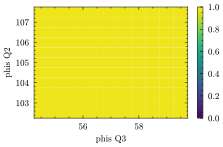

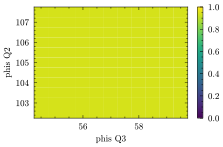

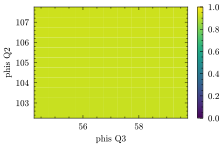

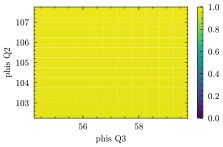

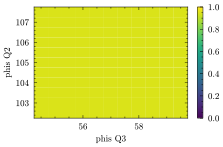

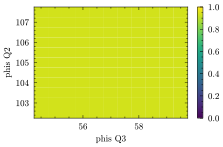

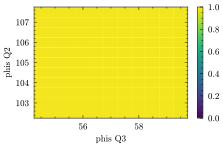

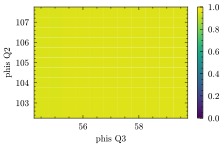

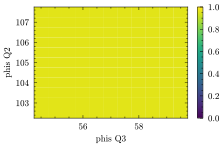

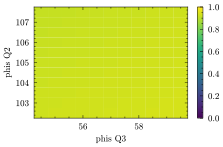

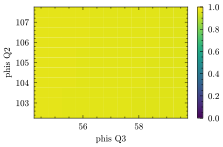

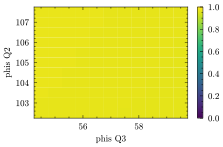

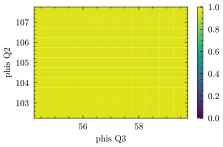

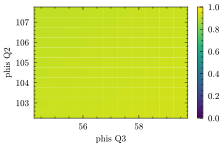

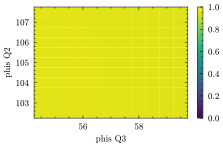

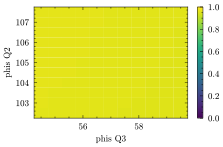

check states ['|0>|0>' '|0>|1>' '|0>|0+1>' '|0>|0+i>' '|1>|0>' '|1>|1>' '|1>|0+1>'
 '|1>|0+i>' '|0+1>|0>' '|0+1>|1>' '|0+1>|0+1>' '|0+1>|0+i>' '|0+i>|0>'
 '|0+i>|1>' '|0+i>|0+1>' '|0+i>|0+i>']
Best fids with individual rotations [0.9729133276605479, 0.9352863377179752, 0.9237949056112174, 0.969994291163189, 0.9442013550852991, 0.9321504789373425, 0.9834312980646663, 0.9487370761911194, 0.9555468664009059, 0.9373308680464357, 0.961369862013129, 0.9687736682171086, 0.9494277901865813, 0.9305170776715163, 0.9598381796576706, 0.9621764948715466]
Avg of best fids with individual rotations 0.9522181173435156
Phis for best fids with individual rotations [[361.5, 103.5, 55.5], [361.5, 105.5, 56.5], [360.5, 107.5, 57.5], [364.5, 107.5, 58.5], [361.5, 103.0, 59.5], [364.5, 104.5, 58.0], [362.5, 105.0, 54.5], [365.0, 104.5, 59.5], [364.0, 102.5, 59.0], [365.5, 102.5, 59.5], [360.5, 105.5, 54.5], [360.5, 107.0, 54.5], [361.5, 104.0, 59.0], [365.5, 102.5, 59.5], [360.5, 102.5, 54.5], [360.5, 107.0,

(array([0.97291333, 0.93528634, 0.92379491, 0.96999429, 0.94420136,
        0.93215048, 0.9834313 , 0.94873708, 0.95554687, 0.93733087,
        0.96136986, 0.96877367, 0.94942779, 0.93051708, 0.95983818,
        0.96217649]),
 array([[361.5, 103.5,  55.5],
        [361.5, 105.5,  56.5],
        [360.5, 107.5,  57.5],
        [364.5, 107.5,  58.5],
        [361.5, 103. ,  59.5],
        [364.5, 104.5,  58. ],
        [362.5, 105. ,  54.5],
        [365. , 104.5,  59.5],
        [364. , 102.5,  59. ],
        [365.5, 102.5,  59.5],
        [360.5, 105.5,  54.5],
        [360.5, 107. ,  54.5],
        [361.5, 104. ,  59. ],
        [365.5, 102.5,  59.5],
        [360.5, 102.5,  54.5],
        [360.5, 107. ,  54.5]]),
 0.9482878441264869,
 [0.972911122492572,
  0.9352826135736461,
  0.9217942340446164,
  0.966440334040538,
  0.9441988397192637,
  0.9321464115741152,
  0.9822578962101352,
  0.9469534034517536,
  0.9555095060411615,
  0.9224092628039705,
  0.95572387084424,
  0.9639301282667

In [18]:
get_optimized_phis(get_fids_grids(os.path.join(data_path, fids_grids_filepath_1protocol)), use_init_2q_state=False, use_ZZ_correction=True, show_fid_grids=True) # ZZ_individual_vs_ideal

In [19]:
def get_fid_name(use_init_2q_state, use_ZZ_correction, use_avg_opt_phis):
    return 'fidelity_' + ('ZZ' if use_ZZ_correction else 'base') + '_rotated_' + ('individual' if not use_avg_opt_phis else 'opt') + '_vs_' + ('meas' if use_init_2q_state else 'ideal')

def get_rho_qram(fids_grids_dict, rho_qram, use_init_2q_state, use_ZZ_correction, individual_best_phis, best_phis_avg_opt):
    init_states = fids_grids_dict["init_states"]

    z_phi123_avg_opt = tomo_analysis.z_gate_nq(best_phis_avg_opt)

    for use_avg_opt_phis in [True, False]:
        fidelity_name = get_fid_name(use_init_2q_state, use_ZZ_correction, use_avg_opt_phis)
        print(f'Calculating {fidelity_name}')
        for i_state, init_state in enumerate(init_states):
            if use_avg_opt_phis:
                z_phi123 = z_phi123_avg_opt
            else:
                z_phi123 = tomo_analysis.z_gate_nq(individual_best_phis[i_state])

            if use_init_2q_state: init_rho = rho_MLE_ZZ_dict[init_state]
            else: init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()

            rho_id = get_qram_qSLR_state_from_rho(init_rho)

            n_tomo_corrected = fids_grids_dict[init_state]

            rho_MLE = tomo_analysis.get_rho_from_counts(
                n_tomo_raw=n_tomo_corrected,
                n_calib=None,
                correct_readout=False,
                correct_neg_counts=False,
                method='analytical',
                ZZ_correction=use_ZZ_correction,
                evol_mats=evol_mats,
            )

            rho_MLE_rot = (z_phi123*qt.Qobj(rho_MLE, dims=rho_id.dims)*z_phi123.dag()).unit()
            fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2

            rho_MLE_name = 'rho_' + ('ZZ' if use_ZZ_correction else 'base')
            rho_qram[rho_MLE_name].update({init_state:rho_MLE_rot})
            rho_qram[fidelity_name][init_state] = fid_rot
        print(rho_qram[fidelity_name])
        # rho_qram['avg_'+fidelity_name] = np.average(list(rho_qram[fidelity_name].values()))
    return rho_qram

In [20]:
rho_qrams = []
for fids_grids_filepath in fids_grids_filepaths:
# for fids_grids_filepath in fids_grids_filepaths[:1]:
    print()
    rho_qram = {
        'rho_base': {},
        'rho_ZZ': {},

        'fidelity_base_rotated_individual_vs_meas': {},
        'fidelity_base_rotated_individual_vs_ideal': {},
        'fidelity_ZZ_rotated_individual_vs_meas': {},
        'fidelity_ZZ_rotated_individual_vs_ideal': {},
        'fidelity_base_rotated_opt_vs_meas': {},
        'fidelity_base_rotated_opt_vs_ideal': {},
        'fidelity_ZZ_rotated_opt_vs_meas': {},
        'fidelity_ZZ_rotated_opt_vs_ideal': {},
        }
    fids_grids_dict = get_fids_grids(os.path.join(data_path, fids_grids_filepath))
    for use_init_2q_state in [True, False]:
        for use_ZZ_correction in [True, False]:
            individual_best_fids, individual_best_phis, best_avg_fid_avg_opt, best_fids_avg_opt, best_phis_avg_opt = get_optimized_phis(
                fids_grids_dict, use_init_2q_state, use_ZZ_correction, show_fid_grids=False,
                scan="fine",
                # scan="coarse",
                )
            rho_qram = get_rho_qram(fids_grids_dict, rho_qram, use_init_2q_state, use_ZZ_correction, individual_best_phis, best_phis_avg_opt)
            print()
    rho_qrams.append(rho_qram)
# print(rho_qram)


Using fids_grids_dict from file S:\QRAM\qram_4QR2\data\data_250119\202502120248_ntomocorrected_3Q_023_fids_grids.npz
fids_grids_dict retrieved with init_states
['|0>|0>' '|0>|1>' '|0>|0+1>' '|0>|0+i>' '|1>|0>' '|1>|1>' '|1>|0+1>'
 '|1>|0+i>' '|0+1>|0>' '|0+1>|1>' '|0+1>|0+1>' '|0+1>|0+i>' '|0+i>|0>'
 '|0+i>|1>' '|0+i>|0+1>' '|0+i>|0+i>']
dict_keys(['|0>|0>', '|0>|1>', '|0>|0+1>', '|0>|0+i>', '|1>|0>', '|1>|1>', '|1>|0+1>', '|1>|0+i>', '|0+1>|0>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0+i>', '|0+i>|0>', '|0+i>|1>', '|0+i>|0+1>', '|0+i>|0+i>'])
play_pulses [2, 1, 3, 4]
using scan fine
check states ['|0>|0>' '|0>|1>' '|0>|0+1>' '|0>|0+i>' '|1>|0>' '|1>|1>' '|1>|0+1>'
 '|1>|0+i>' '|0+1>|0>' '|0+1>|1>' '|0+1>|0+1>' '|0+1>|0+i>' '|0+i>|0>'
 '|0+i>|1>' '|0+i>|0+1>' '|0+i>|0+i>']
Best fids with individual rotations [0.9789106892091076, 0.9485856340370112, 0.9552842574890315, 0.9705668009014571, 0.9713308154230471, 0.8850577544899775, 0.9183500496884864, 0.975901025924804, 0.9727770250486747, 0.958

 s:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1178ComplexWarning: Casting complex values to real discards the imaginary part
 s:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1183

{'|0>|0>': 0.9787047141886532, '|0>|1>': 0.948233174132195, '|0>|0+1>': 0.9535895071350081, '|0>|0+i>': 0.9672958086060099, '|1>|0>': 0.9706871758380252, '|1>|1>': 0.8816622674992429, '|1>|0+1>': 0.9136703995197664, '|1>|0+i>': 0.9757106258481676, '|0+1>|0>': 0.9724847310740848, '|0+1>|1>': 0.9540480809864796, '|0+1>|0+1>': 0.9746746202943086, '|0+1>|0+i>': 0.9669773493546165, '|0+i>|0>': 0.975018976984768, '|0+i>|1>': 0.9313160324368311, '|0+i>|0+1>': 0.957588264788115, '|0+i>|0+i>': 0.9716672620659068}
Calculating fidelity_ZZ_rotated_individual_vs_meas
{'|0>|0>': 0.9789106892091076, '|0>|1>': 0.9485856340370112, '|0>|0+1>': 0.9552842574890315, '|0>|0+i>': 0.9705668009014571, '|1>|0>': 0.9713308154230471, '|1>|1>': 0.8850577544899775, '|1>|0+1>': 0.9183500496884864, '|1>|0+i>': 0.975901025924804, '|0+1>|0>': 0.9727770250486747, '|0+1>|1>': 0.9580615656319519, '|0+1>|0+1>': 0.9775460210973127, '|0+1>|0+i>': 0.9684922423843341, '|0+i>|0>': 0.9758021586990047, '|0+i>|1>': 0.9356243867224

# Plotting

## Decay of fidelity over number of protocols

Average over init states, binned into cqs

In [21]:
# use_fid = 'fidelity_ZZ_rotated_individual_vs_meas'
use_fid = 'fidelity_ZZ_rotated_opt_vs_ideal'
check_init_states = None # set to None to average over all states, otherwise will only average over specified states

In [22]:
x_sweep = [0, 1, 2, 3]

CQ_fids_dict_all_files = dict(
    CrCi=[], # average fid for each state in this category from all files
    CrQi=[],
    QrCi=[],
    QrQi=[],
)

init_states = rho_qrams[0][use_fid].keys()

for i_file, rho_qram in enumerate(rho_qrams):
    CQ_fids_dict = dict(
        CrCi=[], # fid for each state in this category from this file
        CrQi=[],
        QrCi=[],
        QrQi=[],
    )
    fids = rho_qram[use_fid] # dict: init_state -> fidelity for given number of protocols
    print(fids)
    for i, init_state in enumerate(init_states):
        if check_init_states is not None and init_state not in check_init_states: continue
        cq = CQ_from_init(init_state)
        CQ_fids_dict[cq].append(fids[init_state])
        print(f"from file {i_file} adding fid {fids[init_state]} of {init_state} to {cq}")
    for cq in CQ_fids_dict.keys():
        # CQ_fids_dict_all_files[cq].append(np.average(CQ_fids_dict[cq]))
        CQ_fids_dict_all_files[cq].append(CQ_fids_dict[cq])

{'|0>|0>': 0.972911122492572, '|0>|1>': 0.9352826135736461, '|0>|0+1>': 0.9217942340446164, '|0>|0+i>': 0.966440334040538, '|1>|0>': 0.9441988397192637, '|1>|1>': 0.9321464115741152, '|1>|0+1>': 0.9822578962101352, '|1>|0+i>': 0.9469534034517536, '|0+1>|0>': 0.9555095060411615, '|0+1>|1>': 0.9224092628039705, '|0+1>|0+1>': 0.95572387084424, '|0+1>|0+i>': 0.9639301282667891, '|0+i>|0>': 0.9488596171822883, '|0+i>|1>': 0.9156610771515201, '|0+i>|0+1>': 0.9523655824433112, '|0+i>|0+i>': 0.9561616061838697}
from file 0 adding fid 0.972911122492572 of |0>|0> to CrCi
from file 0 adding fid 0.9352826135736461 of |0>|1> to CrCi
from file 0 adding fid 0.9217942340446164 of |0>|0+1> to CrQi
from file 0 adding fid 0.966440334040538 of |0>|0+i> to CrQi
from file 0 adding fid 0.9441988397192637 of |1>|0> to CrCi
from file 0 adding fid 0.9321464115741152 of |1>|1> to CrCi
from file 0 adding fid 0.9822578962101352 of |1>|0+1> to CrQi
from file 0 adding fid 0.9469534034517536 of |1>|0+i> to CrQi
from 

In [25]:
saveplot = True

# fig, ax = plt.subplots(1, 1, figsize=(5, 3))
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
plt.grid()

def fit_func(depth, p, a):
    return a * p**depth

avg_err_per_U_cqs = []
avg_err_per_U_err_cqs = []

for cq in CQ_fids_dict_all_files.keys():
    print(cq)
    fids_per_U_all_cq = CQ_fids_dict_all_files[cq] # shape: n_files x n_states_per_cq
    fids_per_U = np.average(fids_per_U_all_cq, axis=1)

    plt.plot(range(len(fids_per_U)), fids_per_U, 'o-', color=color_from_cq(cq), markersize=5)
    # yerr = np.array([fids_per_U - np.min(fids_per_U_all_cq, axis=1), np.max(fids_per_U_all_cq, axis=1) - fids_per_U])
    # print('yerr', yerr)
    # plt.errorbar(range(len(fids_per_U)), fids_per_U, yerr=yerr, fmt='o-', color=color_from_cq(cq), markersize=5)

    # err_per_U = np.diff(fids_per_U)
    # avg_err_per_U = np.average(np.abs(err_per_U))/2

    # --- Get error by dividing by previous fidelity --- 
    # denominator = np.roll(fids_per_U, 1)[1:]
    # gate_fids_per_U2 = fids_per_U[1:] / denominator
    # gate_fids_per_U = np.sqrt(gate_fids_per_U2)
    # err_per_U = 1 - gate_fids_per_U
    # avg_err_per_U = np.average(np.abs(err_per_U))
    # print("denominator", denominator)

    # print("fids_per_U", fids_per_U)
    # print("err_per_U", err_per_U)
    # print("avg_err_per_U", avg_err_per_U)

    # n_fit = np.arange(0, len(fids_per_U)
    # err_fit = fids_per_U[0]*(1 - avg_err_per_U)**(2*n_fit)

    # plt.plot(n_fit, err_fit, '--', label="$\epsilon$="+f"{avg_err_per_U*100:.2}%", color=color_from_cq(cq), markersize=5)

    # --- Get error by fit --- 
    n_fit_plot = 1 + 2*np.arange(0, len(fids_per_U))
    n_fit = np.repeat(n_fit_plot, np.array(fids_per_U_all_cq).shape[1]).flatten()
    x_plot = np.arange(0, len(fids_per_U))
    # print(n_fit_plot)

    # p, pcov = meas.fitting.fitrb(n_fit, np.array(fids_per_U_all_cq).flatten())
    # print("offset", p[2], np.sqrt(pcov[2, 2]))
    p, pcov = sp.optimize.curve_fit(fit_func, n_fit, np.array(fids_per_U_all_cq).flatten())
    avg_err_per_U = 1 - p[0]
    avg_err_per_U_err = np.sqrt(pcov[0, 0])
    avg_err_per_U_cqs.append(avg_err_per_U)
    avg_err_per_U_err_cqs.append(avg_err_per_U_err)

    print("fids_per_U", fids_per_U)
    print("avg_err_per_U", avg_err_per_U)

    # plt.plot(x_plot, meas.fitting.rb_func(n_fit_plot, *p), '--', label="$\epsilon$: "+f"{avg_err_per_U*100:.2} $\pm$ {z*avg_err_per_U_err*100:.2}%", color=color_from_cq(cq), markersize=5)
    plt.plot(x_plot, fit_func(n_fit_plot, *p), '--', label="$\epsilon$: "+f"{np.round(avg_err_per_U*100, 1):.2} $\pm$ {ceil_decimal(z*avg_err_per_U_err*100, 1):.2}%", color=color_from_cq(cq), markersize=5)

    # plt.plot(range(len(err_per_U)), err_per_U, 'o-', label="$\epsilon$: "+f"{avg_err_per_U*100:.2}%", color=color_from_cq(cq), markersize=5)
avg_err_err_avg = np.sqrt(np.sum(np.array(avg_err_per_U_err_cqs)**2)) / len(avg_err_per_U_err_cqs)
print(f"Average fidelity per U: {100*(1 - np.average(avg_err_per_U_cqs))} $\pm$ {100*z*np.average(avg_err_err_avg)}")

ax.set_xticks(range(len(fids_per_U)))
ymin = 0.45
ymax = 1.0
ytick_spacing = 0.2
ytick_labels = np.round(np.linspace(ymin, ymax, int(np.ceil((ymax-ymin)/ytick_spacing))+1) /ytick_spacing) * ytick_spacing
ax.set_yticks(ytick_labels)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('$N$ for $(U_{\mathrm{route}}U_{\mathrm{route}}^{-1})^N U_{\mathrm{route}}$', fontsize=16)
plt.ylabel('Average Fidelity', fontsize=16)
plt.ylim(ymin, ymax)
plt.legend(fontsize=14, loc="lower left", bbox_to_anchor=(-0.02, -0.035), frameon=False) #frameon=True, framealpha=0.5)
plt.tight_layout()

fids_grids_filepaths_str = '_'.join([fids_grids_filepath[:12] for fids_grids_filepath in fids_grids_filepaths])
filename = f'tomo\protocol_repeat_{use_fid}_{fids_grids_filepaths_str}'
print(filename)

if saveplot:
    savename = os.path.join(save_plot_path, filename+'.svg')
    plt.savefig(savename, bbox_inches='tight')
    print("Saved svg plot", savename)

    savename = os.path.join(save_plot_path, filename+'.pdf')
    plt.savefig(savename, bbox_inches='tight')
    print("Saved pdf plot", savename)

    plt.close()
else:
    plt.show()

CrCi
fids_per_U [0.94613475 0.9085199  0.86069073 0.83769895 0.81729593 0.83124381]
avg_err_per_U 0.014477796647246466
CrQi
fids_per_U [0.95436147 0.84803862 0.80689495 0.75970386 0.7758418  0.66526852]
avg_err_per_U 0.030273174004100123
QrCi
fids_per_U [0.93560987 0.89247926 0.77875091 0.75569007 0.77155345 0.69332226]
avg_err_per_U 0.028385679906962724
QrQi
fids_per_U [0.9570453  0.85894922 0.74585617 0.70124346 0.69746573 0.60804271]
avg_err_per_U 0.042672208992907024
Average fidelity per U: 97.10477851121959 $\pm$ 0.5818931094135827
tomo\protocol_repeat_fidelity_ZZ_rotated_opt_vs_ideal_202502120248_202502120636_202502121025_202502121415_202502130312_202502130703
Saved svg plot S:\QRAM\qram_4QR2\plots\paper\tomo\protocol_repeat_fidelity_ZZ_rotated_opt_vs_ideal_202502120248_202502120636_202502121025_202502121415_202502130312_202502130703.svg
Saved pdf plot S:\QRAM\qram_4QR2\plots\paper\tomo\protocol_repeat_fidelity_ZZ_rotated_opt_vs_ideal_202502120248_202502120636_202502121025_202502

## Error breakdown

In [ ]:
x_sweep = [0, 1, 2, 3]

i_file = 0 # index in file list to use the data from
init_states = fids_grids_dict["init_states"]

CQ_avg_fids_dict_processing_dict = dict() # dict: use_fid -> CQ -> average fid
CQ_fids_dict_processing_dict = dict() # dict: use_fid -> CQ -> average fid
for use_init_2q_state in [True, False]:
    for use_ZZ_correction in [True, False]:
        for use_avg_opt_phis in [True, False]:
            print("starting", use_init_2q_state, use_ZZ_correction, use_avg_opt_phis)
            use_fid = get_fid_name(use_init_2q_state, use_ZZ_correction, use_avg_opt_phis)

            CQ_fids_dict = dict(
                CrCi=[], # fid for each state in this category from this file
                CrQi=[],
                QrCi=[],
                QrQi=[],
            )
            CQ_avg_fids_dict = dict(
                CrCi=0, # fid for each state in this category from this file
                CrQi=0,
                QrCi=0,
                QrQi=0,
            )

            rho_qram = rho_qrams[i_file]
            fids = rho_qram[use_fid] # dict: init_state -> fidelity for given number of protocols
            # print(fids)
            for i, init_state in enumerate(init_states):
                if check_init_states is not None and init_state not in check_init_states: continue
                cq = CQ_from_init(init_state)
                CQ_fids_dict[cq].append(fids[init_state])
                print(f"from file {i_file} adding fid {fids[init_state]} of {init_state} to {cq}")
            for cq in CQ_fids_dict.keys():
                print(f"from file {i_file} {cq} fids are", CQ_fids_dict[cq])
                CQ_avg_fids_dict[cq] = np.average(CQ_fids_dict[cq])

            CQ_fids_dict_processing_dict[use_fid] = CQ_fids_dict
            CQ_avg_fids_dict_processing_dict[use_fid] = CQ_avg_fids_dict

for key in CQ_fids_dict_processing_dict.keys():
    print(key)
    print(CQ_fids_dict_processing_dict[key])
    print('average', CQ_avg_fids_dict_processing_dict[key])

starting True True True
from file 0 adding fid 0.9787047141886532 of |0>|0> to CrCi
from file 0 adding fid 0.948233174132195 of |0>|1> to CrCi
from file 0 adding fid 0.9535895071350081 of |0>|0+1> to CrQi
from file 0 adding fid 0.9672958086060099 of |0>|0+i> to CrQi
from file 0 adding fid 0.9706871758380252 of |1>|0> to CrCi
from file 0 adding fid 0.8816622674992429 of |1>|1> to CrCi
from file 0 adding fid 0.9136703995197664 of |1>|0+1> to CrQi
from file 0 adding fid 0.9757106258481676 of |1>|0+i> to CrQi
from file 0 adding fid 0.9724847310740848 of |0+1>|0> to QrCi
from file 0 adding fid 0.9540480809864796 of |0+1>|1> to QrCi
from file 0 adding fid 0.9746746202943086 of |0+1>|0+1> to QrQi
from file 0 adding fid 0.9669773493546165 of |0+1>|0+i> to QrQi
from file 0 adding fid 0.975018976984768 of |0+i>|0> to QrCi
from file 0 adding fid 0.9313160324368311 of |0+i>|1> to QrCi
from file 0 adding fid 0.957588264788115 of |0+i>|0+1> to QrQi
from file 0 adding fid 0.9716672620659068 of |0+i>|

Fidelities bar chart

In [ ]:
saveplot = True

# fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
cqs = ['CrCi', 'CrQi', 'QrCi', 'QrQi']
cq_labels = [latex_from_cq(cq) for cq in cqs]

use_ZZ_correction = True

# use_fid = get_fid_name(use_init_2q_state=True, use_ZZ_correction=False, use_avg_opt_phis=True)
# fids = [CQ_avg_fids_dict_processing_dict[use_fid][cq] for cq in cqs]
fid_theory = dict(
    CrCi = 0.9795465754354343,
    QrCi = 0.97274267574603,
    CrQi = 0.9727978474810874,
    QrQi = 0.9660012105228144,
)
fids = [fid_theory[cq] for cq in cqs]
colors_cq = [color_from_cq(cq) for cq in cqs]
ax.bar(cq_labels, fids, color=colors_cq, alpha=1.0, edgecolor=colors_cq, linewidth=2.0, linestyle='-', fill=False, label='Theory')

# use_fid = get_fid_name(use_init_2q_state=True, use_ZZ_correction=False, use_avg_opt_phis=True)
# fids = [CQ_avg_fids_dict_processing_dict[use_fid][cq] for cq in cqs]
# colors_cq = [color_from_cq(cq) for cq in cqs]
# ax.bar(cq_labels, fids, color=colors_cq, alpha=1.0, edgecolor=colors_cq, linewidth=0.75, linestyle='--', fill=False, label='Base, $\\vec{\phi}_0$')

use_fid = get_fid_name(use_init_2q_state=False, use_ZZ_correction=use_ZZ_correction, use_avg_opt_phis=True)
label = '$\\rho_{\mathrm{ideal}}$, $\\vec{\phi}_0$'
fids = [CQ_avg_fids_dict_processing_dict[use_fid][cq] for cq in cqs]
colors_cq = [color_from_cq(cq) for cq in cqs]
ax.bar(cq_labels, fids, color=colors_cq, alpha=0.5, edgecolor=colors_cq, linewidth=0.0, fill=True, label=label)

use_fid = get_fid_name(use_init_2q_state=True, use_ZZ_correction=use_ZZ_correction, use_avg_opt_phis=True)
label = '$\\rho_{\mathrm{meas}}$, $\\vec{\phi}_0$'
fids = [CQ_avg_fids_dict_processing_dict[use_fid][cq] for cq in cqs]
colors_cq = [color_from_cq(cq) for cq in cqs]
ax.bar(cq_labels, fids, color=colors_cq, alpha=1.0, edgecolor=colors_cq, linewidth=2.0, linestyle='--', fill=False, label=label)

use_fid = get_fid_name(use_init_2q_state=True, use_ZZ_correction=use_ZZ_correction, use_avg_opt_phis=False)
label = '$\\rho_{\mathrm{meas}}$, $\{ \\vec{\phi}_k\}$'
fids = [CQ_avg_fids_dict_processing_dict[use_fid][cq] for cq in cqs]
colors_cq = [color_from_cq(cq) for cq in cqs]
ax.bar(cq_labels, fids, color=colors_cq, alpha=1.0, edgecolor=colors_cq, linewidth=2.0, linestyle=':', fill=False, label=label)


ymin = 0.80
ymax = 1.01
ytick_spacing = 0.1
ytick_labels = np.round(np.linspace(ymin, ymax, int(np.ceil((ymax-ymin)/ytick_spacing))+1) /ytick_spacing) * ytick_spacing
ax.set_yticks(ytick_labels)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
# for tick in ax.get_xticklabels(): # tilt the x labels by 45 degrees
    # tick.set_rotation(45)
plt.ylabel('Average Fidelity', fontsize=16)
plt.ylim(ymin, ymax)
# plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', frameon=True, edgecolor='k', fontsize=13) # bbox is where to put box, loc is which corner of box is anchored
plt.legend(bbox_to_anchor=(0.45, -0.1), loc='upper center', frameon=True, edgecolor='k', fontsize=16, ncol=2) # bbox is where to put box, loc is which corner of box is anchored
# plt.tight_layout()

fids_grids_filepaths_str = fids_grids_filepaths[0][:12]
filename = f'tomo\cq_fid_breakdown_1protocol_{fids_grids_filepaths_str}'
print(filename)
if saveplot:
    savename = os.path.join(save_plot_path, filename+'.svg')
    plt.savefig(savename, bbox_inches='tight')
    print("Saved svg plot", savename)

    savename = os.path.join(save_plot_path, filename+'.pdf')
    plt.savefig(savename, bbox_inches='tight')
    print("Saved pdf plot", savename)

    plt.close()
else:
    plt.show()

tomo\cq_fid_breakdown_1protocol_202502120248
Saved svg plot S:\QRAM\qram_4QR2\plots\paper\tomo\cq_fid_breakdown_1protocol_202502120248.svg
Saved pdf plot S:\QRAM\qram_4QR2\plots\paper\tomo\cq_fid_breakdown_1protocol_202502120248.pdf


Errors bar chart

In [ ]:
import matplotlib as mpl

saveplot = True

# fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.grid(axis='y', which='both')
cqs = ['CrCi', 'CrQi', 'QrCi', 'QrQi']
cq_labels = [latex_from_cq(cq) for cq in cqs]
colors_cq = [color_from_cq(cq) for cq in cqs]
rgbcolors_cq = [mcolors.to_rgb(c) for c in colors_cq]

use_ZZ_correction = True

bottom = np.zeros(len(cqs))

use_fid = get_fid_name(use_init_2q_state=False, use_ZZ_correction=use_ZZ_correction, use_avg_opt_phis=True)
fids_id_global = np.array([CQ_fids_dict_processing_dict[use_fid][cq] for cq in cqs])
avg_fids_id_global = np.average(fids_id_global, axis=1)

use_fid = get_fid_name(use_init_2q_state=False, use_ZZ_correction=use_ZZ_correction, use_avg_opt_phis=False)
fids_id_individual = np.array([CQ_fids_dict_processing_dict[use_fid][cq] for cq in cqs])

use_fid = get_fid_name(use_init_2q_state=True, use_ZZ_correction=use_ZZ_correction, use_avg_opt_phis=True)
fids_meas_global = np.array([CQ_fids_dict_processing_dict[use_fid][cq] for cq in cqs])

use_fid = get_fid_name(use_init_2q_state=True, use_ZZ_correction=use_ZZ_correction, use_avg_opt_phis=False)
fids_meas_individual = np.array([CQ_fids_dict_processing_dict[use_fid][cq] for cq in cqs])

label = "Total Error"
errs = 1 - avg_fids_id_global
ax.bar(cq_labels, errs, alpha=0.6, color='w', edgecolor='k', linewidth=2.0, linestyle='-', fill=True, label=label, bottom=np.zeros(len(cqs)))

# use_fid = get_fid_name(use_init_2q_state=True, use_ZZ_correction=False, use_avg_opt_phis=True)
# fids = [CQ_fids_dict_processing_dict[use_fid][cq] for cq in cqs]
label = "Decoherence\n(Theory)"
errs = [1 - fid_theory[cq] for cq in cqs]
print('decoherence errs (%)', 100*np.array(errs))
print('average decoherence errs (%)', np.average(np.array(errs))*100)
facecolors = [(*rgbcolors_cq[c], 0.25) for c in range(len(cqs))]
edgecolors = [(*rgbcolors_cq[c], 1.0) for c in range(len(cqs))]
ax.bar(cq_labels, errs, color=facecolors, edgecolor=edgecolors, linewidth=2.0, fill=True, label=label, bottom=bottom)
bottom += errs

label = "Timing Errors"
errs = np.abs(fids_id_individual - fids_id_global)
errs = np.average(errs, axis=1)
print('timing errs (%)', 100*errs)
print('average timing errs (%)', np.average(errs)*100)
facecolors = [(*rgbcolors_cq[c], 0.75) for c in range(len(cqs))]
edgecolors = [(*rgbcolors_cq[c], 1.0) for c in range(len(cqs))]
# ax.bar(cq_labels, errs, color=facecolors, edgecolor=edgecolors, linewidth=2.0, fill=True, label=label, bottom=bottom)
# bottom += errs

label = "Initial State\nSPAM"
errs = np.abs(fids_meas_individual - fids_id_individual)
# errs = (fids_meas_individual - fids_id_individual)
# print('errs here', errs)
errs = np.average(errs, axis=1)
print('spam errs (%)', errs*100)
print('average spam errs (%)', np.average(errs)*100)
facecolors = [(*rgbcolors_cq[c], 0.0) for c in range(len(cqs))]
edgecolors = [(*rgbcolors_cq[c], 1.0) for c in range(len(cqs))]
mpl.rcParams['hatch.linewidth'] = 1.0
ax.bar(cq_labels, errs, color=facecolors, edgecolor=edgecolors, linewidth=2.0, hatch='///', label=label, bottom=bottom)
bottom += errs

print('bottom', bottom)

# Labels for total error
labels = ["$\\bar{\\mathcal{F}}: $" + f"{fid:.3}%" for fid in 100*avg_fids_id_global]
rects = ax.patches
for i, (rect, label) in enumerate(zip(rects, labels)):
    height = max((1-avg_fids_id_global[i], bottom[i]))
    # print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0.003, label, ha="center", va="bottom", color='k', fontsize=14
    )


ymin = 0.0
ymax = 0.1
ytick_spacing = 0.05
ytick_labels = np.round(np.linspace(ymin, ymax, int(np.ceil((ymax-ymin)/ytick_spacing))+1) /ytick_spacing) * ytick_spacing
ax.set_yticks(ytick_labels, labels=100*ytick_labels) # scale y axis to percent
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
# for tick in ax.get_xticklabels(): # tilt the x labels by 45 degrees
    # tick.set_rotation(45)
plt.ylabel('Error Contribution (%)', fontsize=16)
plt.ylim(ymin, ymax)
# plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', frameon=True, edgecolor='k', fontsize=13) # bbox is where to put box, loc is which corner of box is anchored
plt.legend(bbox_to_anchor=(0.45, -0.1), loc='upper center', frameon=True, edgecolor='k', fontsize=16, ncol=2) # bbox is where to put box, loc is which corner of box is anchored
# plt.tight_layout()

errs_grids_filepaths_str = fids_grids_filepaths[0][:12]
filename = f'supmat\cq_err_breakdown_1protocol_{errs_grids_filepaths_str}'
print(filename)
if saveplot:
    savename = os.path.join(save_plot_path, filename+'.svg')
    plt.savefig(savename, bbox_inches='tight')
    print("Saved svg plot", savename)

    savename = os.path.join(save_plot_path, filename+'.pdf')
    plt.savefig(savename, bbox_inches='tight')
    print("Saved pdf plot", savename)

    plt.close()
else:
    plt.show()

decoherence errs (%) [2.04534246 2.72021525 2.72573243 3.39987895]
average decoherence errs (%) 2.7227922703658454
timing errs (%) [3.12801039e-04 2.12792582e-01 7.59578478e-01 5.99425426e-01]
average timing errs (%) 0.3930273217028782
spam errs (%) [2.33797107 3.10767649 1.73606334 0.78574727]
average spam errs (%) 1.991864543071578
bottom [0.04383314 0.05827892 0.04461796 0.04185626]
supmat\cq_err_breakdown_1protocol_202502120248
Saved svg plot S:\QRAM\qram_4QR2\plots\paper\supmat\cq_err_breakdown_1protocol_202502120248.svg
Saved pdf plot S:\QRAM\qram_4QR2\plots\paper\supmat\cq_err_breakdown_1protocol_202502120248.pdf


# Tomo plots for supmat

In [ ]:
use_fid = 'fidelity_ZZ_rotated_individual_vs_meas'
# use_fid = 'fidelity_ZZ_rotated_opt_vs_ideal'

use_ZZ_correction = True

In [ ]:
init_state = "|0+1>|1>"

init_state_title = ""
for c in init_state:
    if c != ">": init_state_title += c
    else: init_state_title += "\\rangle"

0plus1-1
Saved S:\QRAM\qram_4QR2\plots\paper\supmat\tomo_2q_0plus1-1_202502120248.svg


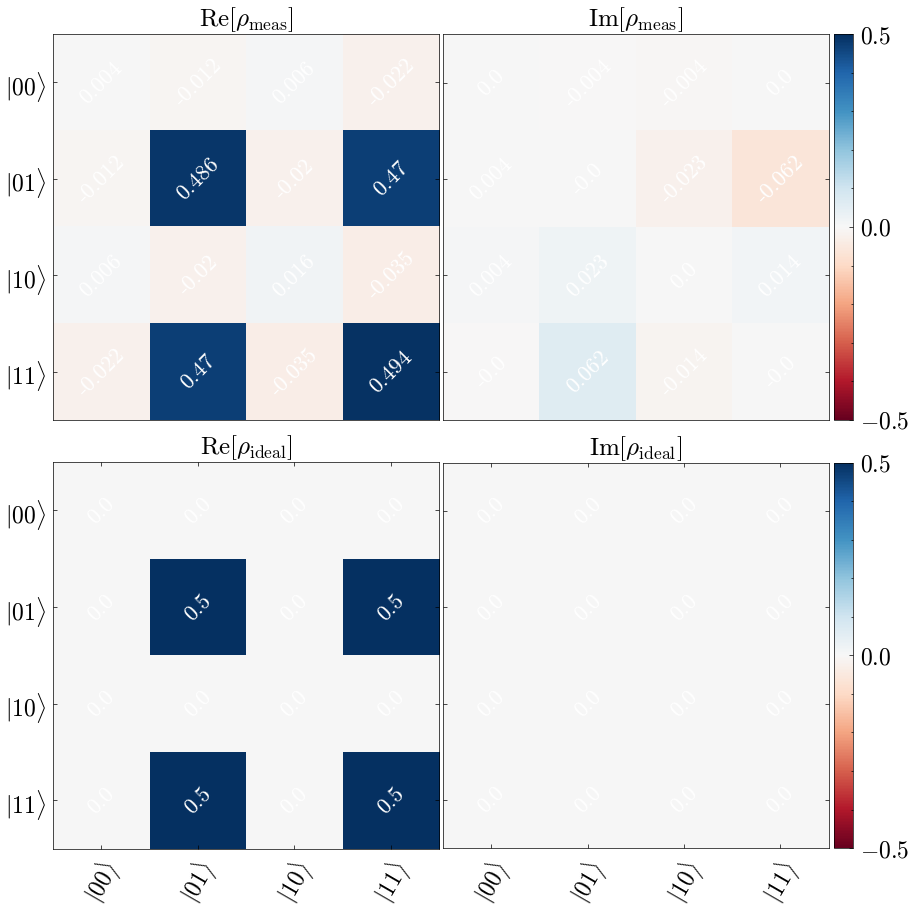

In [ ]:
tomo_analysis = TomoAnalysis(2)
rho_meas_2q = rho_MLE_ZZ_dict[init_state]
rho_id_2q = qt.ket2dm(name_to_state_2q(init_state)).full()

filepaths_str = fids_grids_filepaths[0][:12]
init_state_savename = init_state.replace(">|", "-")
init_state_savename = init_state_savename.replace("|", "")
init_state_savename = init_state_savename.replace(">", "")
init_state_savename = init_state_savename.replace("+", "plus")
print(init_state_savename)
filename = f'supmat\\tomo_2q_{init_state_savename}_{filepaths_str}'
savename = os.path.join(save_plot_path, filename+'.svg')
# print(savename)

# fig = tomo_analysis.show_plot_rho_2d(
#     rho_test=rho_meas_2q,
#     rho_id=rho_id_2q,
#     # title=f"Target State: ${init_state_title}$",
#     title="",
#     state_num=True,
#     cmax=0.5,
#     ideal_name="ideal",
#     savetitle=savename,
#     )

rho_test = rho_meas_2q
rho_id = rho_id_2q
labels = [f"$|{state}\\rangle$" for state in tomo_analysis.calib_order_numeric]
tick_rotation = 60
ideal_name = "ideal"

width = 10.0
height = 11.0
size = (width, height)
cmax = 0.5

fig, axes = plt.subplots(2, 2, figsize=size, gridspec_kw={"width_ratios": [1, 1.06], "height_ratios":[1, 1]})
left = 0.1
wspace = 0.01
plt.subplots_adjust(left=left, right=1-left, wspace=wspace, hspace=wspace/1.0) 
# plt.suptitle(title, fontsize=18, y=1.05)
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]
tomo_analysis.show_mat_2d(
    np.real(rho_test),
    ax=ax1,
    title="Re[$\\rho_{\\mathrm{meas}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=False,
    show_xticks=False,
    show_yticks=True,
    show=False,
    tick_rotation=tick_rotation,
)
tomo_analysis.show_mat_2d(
    np.imag(rho_test),
    ax=ax2,
    title="Im[$\\rho_{\\mathrm{meas}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=True,
    show_xticks=False,
    show_yticks=False,
    show=False,
    tick_rotation=tick_rotation,
)
tomo_analysis.show_mat_2d(
    np.real(rho_id),
    ax=ax3,
    title="Re[$\\rho_{\\mathrm{" + ideal_name + "}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=False,
    show_yticks=True,
    show=False,
    tick_rotation=tick_rotation,
)
tomo_analysis.show_mat_2d(
    np.imag(rho_id),
    ax=ax4,
    title="Im[$\\rho_{\\mathrm{" + ideal_name + "}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=True,
    show_yticks=False,
    show=False,
    tick_rotation=tick_rotation,
)

filename = f'supmat\\tomo_2q_{init_state_savename}_{filepaths_str}'
savename = os.path.join(save_plot_path, filename+'.svg')
plt.savefig(savename, bbox_inches="tight", transparent=True)
print("Saved", savename)

plt.show()

0plus1-1
Saved S:\QRAM\qram_4QR2\plots\paper\supmat\tomo_3q_0plus1-1_202502120248.svg


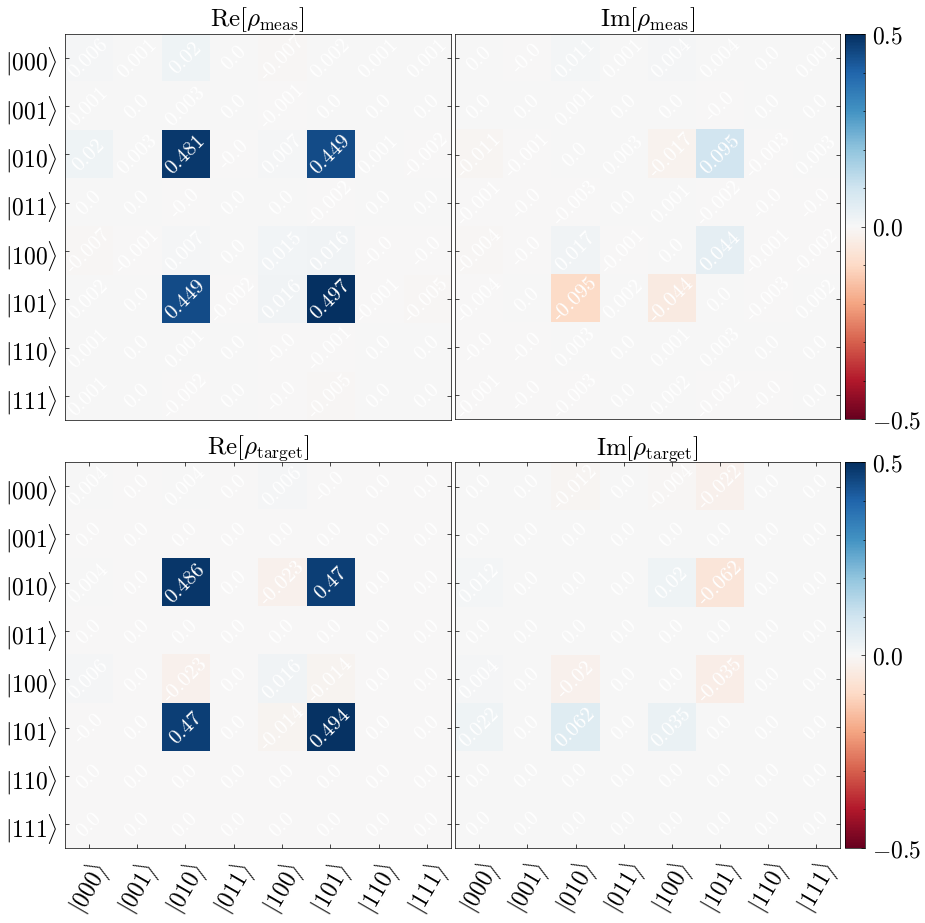

In [ ]:
rho_meas_3q = rho_qrams[0][f"rho_{'ZZ' if use_ZZ_correction else 'base'}"][init_state]
rho_id_3q = get_qram_qSLR_state_from_rho(rho_meas_2q)

tomo_analysis = TomoAnalysis(3)

filepaths_str = fids_grids_filepaths[0][:12]
init_state_savename = init_state.replace(">|", "-")
init_state_savename = init_state_savename.replace("|", "")
init_state_savename = init_state_savename.replace(">", "")
init_state_savename = init_state_savename.replace("+", "plus")
print(init_state_savename)

# fig = tomo_analysis.show_plot_rho_2d(
#     rho_test=rho_meas_3q,
#     rho_id=rho_id_3q,
#     # title=f"Target State: ${init_state_title}$",
#     title="",
#     state_num=True,
#     cmax=0.5,
#     ideal_name="target",
#     savetitle=savename,
#     )

rho_test = rho_meas_3q
rho_id = rho_id_3q
labels = [f"$|{state}\\rangle$" for state in tomo_analysis.calib_order_numeric]
tick_rotation = 60
ideal_name = "target"

width = 10.0
height = 11.0
size = (width, height)
cmax = 0.5

fig, axes = plt.subplots(2, 2, figsize=size, gridspec_kw={"width_ratios": [1, 1.06], "height_ratios":[1, 1]})
left = 0.1
wspace = 0.01
plt.subplots_adjust(left=left, right=1-left, wspace=wspace, hspace=wspace/1.0) 
# plt.suptitle(title, fontsize=18, y=1.05)
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]
tomo_analysis.show_mat_2d(
    np.real(rho_test),
    ax=ax1,
    title="Re[$\\rho_{\\mathrm{meas}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=False,
    show_xticks=False,
    show_yticks=True,
    show=False,
    tick_rotation=tick_rotation,
)
tomo_analysis.show_mat_2d(
    np.imag(rho_test),
    ax=ax2,
    title="Im[$\\rho_{\\mathrm{meas}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=True,
    show_xticks=False,
    show_yticks=False,
    show=False,
    tick_rotation=tick_rotation,
)
tomo_analysis.show_mat_2d(
    np.real(rho_id),
    ax=ax3,
    title="Re[$\\rho_{\\mathrm{" + ideal_name + "}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=False,
    show_yticks=True,
    show=False,
    tick_rotation=tick_rotation,
)
tomo_analysis.show_mat_2d(
    np.imag(rho_id),
    ax=ax4,
    title="Im[$\\rho_{\\mathrm{" + ideal_name + "}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=True,
    show_yticks=False,
    show=False,
    tick_rotation=tick_rotation,
)

filename = f'supmat\\tomo_3q_{init_state_savename}_{filepaths_str}'
savename = os.path.join(save_plot_path, filename+'.svg')
plt.savefig(savename, bbox_inches="tight", transparent=True)
print("Saved", savename)

plt.show()


0plus1-0plusi
Saved S:\QRAM\qram_4QR2\plots\paper\tomo\tomo_3q_0plus1-0plusi_202502120248.svg


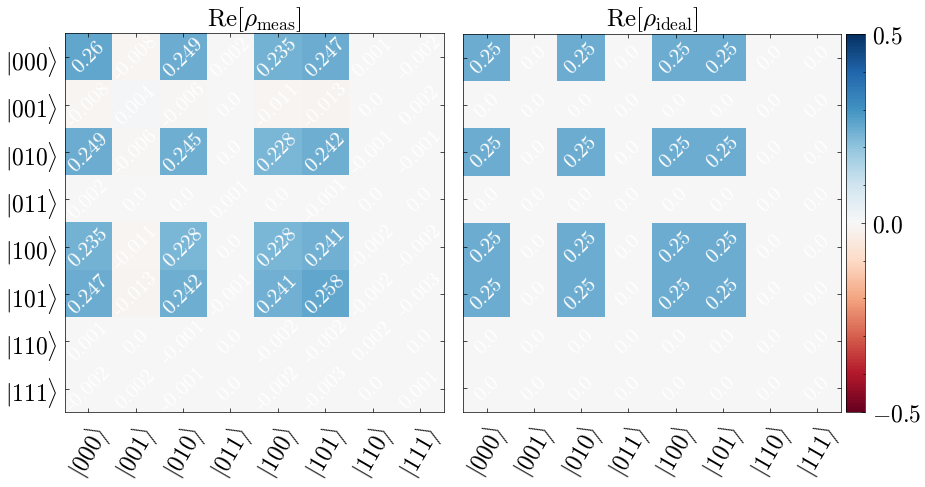

In [ ]:
init_state = "|0+1>|0+i>"
init_state_title = "|+\\rangle|i\\rangle"
init_state_savename = init_state.replace(">|", "-")
init_state_savename = init_state_savename.replace("|", "")
init_state_savename = init_state_savename.replace(">", "")
init_state_savename = init_state_savename.replace("+", "plus")
print(init_state_savename)

rho_meas_3q = rho_qrams[0][f"rho_{'ZZ' if use_ZZ_correction else 'base'}"][init_state]
rho_id_2q = qt.ket2dm(name_to_state_2q(init_state)).full()
rho_id_3q = get_qram_qSLR_state_from_rho(rho_id_2q)

tomo_analysis = TomoAnalysis(3)

title=f"Initial State: ${init_state_title}$"
labels = [f"$|{state}\\rangle$" for state in tomo_analysis.calib_order_numeric]
tick_rotation = 60
ideal_name = "ideal"

width = 10.0
height = 5
size = (width, height)
cmax = 0.5

fig, axes = plt.subplots(1, 2, figsize=size, gridspec_kw={"width_ratios": [1, 1.06]})
left = 0.1
wspace = 0.05
plt.subplots_adjust(left=left, right=1-left, wspace=wspace, hspace=wspace/1.0) 
# plt.suptitle(title, fontsize=18, y=1.05)
ax1 = axes[0]
ax2 = axes[1]
tomo_analysis.show_mat_2d(
    np.real(rho_meas_3q),
    ax=ax1,
    title="Re[$\\rho_{\\mathrm{meas}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=False,
    show_yticks=True,
    show=False,
    tick_rotation=tick_rotation,
)

tomo_analysis.show_mat_2d(
    np.real(rho_id_3q),
    ax=ax2,
    title="Re[$\\rho_{\\mathrm{" + ideal_name + "}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=True,
    show_yticks=False,
    show=False,
    tick_rotation=tick_rotation,
)

# plt.tight_layout()
filename = f'tomo\\tomo_3q_{init_state_savename}_{filepaths_str}'
savename = os.path.join(save_plot_path, filename+'.svg')
plt.savefig(savename, bbox_inches="tight", transparent=True)
print("Saved", savename)

plt.show()
